# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0

from fastai.vision import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True
np.random.seed(42)

In [3]:
sz = 48
bs = 128

# Data 

In [4]:
get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [5]:
tfms = ([crop(size=sz),
        RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
      #RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
      #RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
     [crop(size=sz)])

In [6]:
data = (ImageItemList.from_csv(path=PATH, csv_name=CSV_NAME, folder=TRAIN_NAME, suffix='.tif')
.random_split_by_pct(0.2)
.label_from_df()
.add_test_folder(test_folder=TEST_NAME, label=None)
.transform(tfms)
.databunch(bs=bs, num_workers=nw)
#.normalize(imagenet_stats))
.normalize())

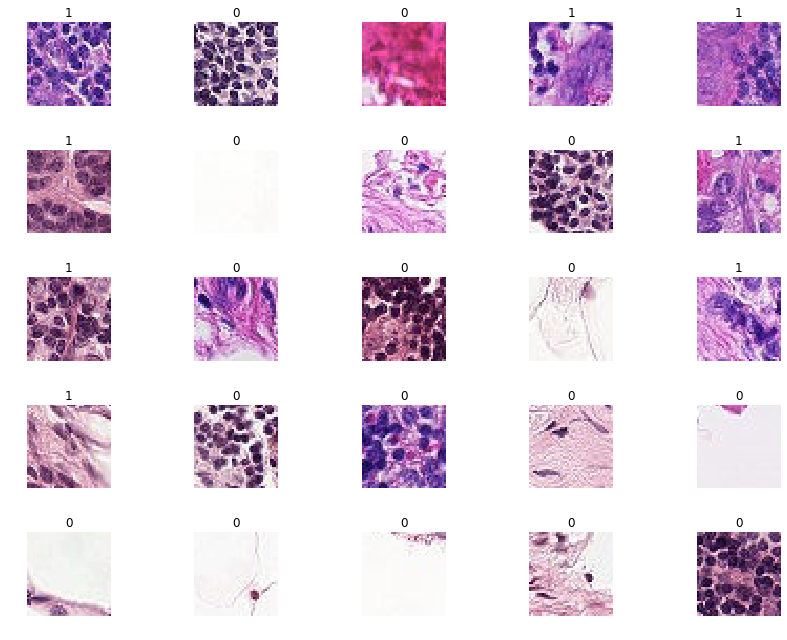

In [36]:
data.show_batch(rows=5, figsize=(12,9))

# Metrics 

In [7]:
def roc_curve_custom(y_pred:torch.Tensor, y_true:torch.Tensor):
    probs = y_pred[:,-1]
    fpr, tpr, thresholds = roc_curve(y_true, probs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def auc_score_1(y_pred:torch.Tensor, y_true:torch.Tensor):
    fpr, tpr, thresholds, roc_auc = roc_curve_custom(y_pred, y_true)
    return torch.as_tensor(roc_auc)

def auc_score_2(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

# Learner

## Create

In [8]:
arch = torchvision.models.densenet169

In [9]:
learner = create_cnn(data=data, 
                     arch=arch, 
                     metrics=[accuracy, auc_score_1, auc_score_2])

/opt/conda/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


## Train

### Multiple cycles

In [5]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


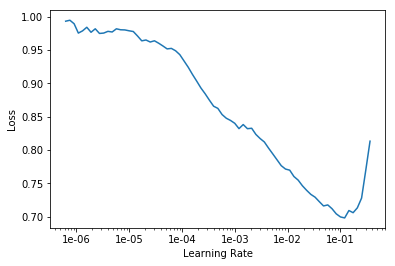

In [6]:
learner.recorder.plot()

In [11]:
lr = 1e-2
cycle_len_head=5

In [ ]:
learner.fit_one_cycle(cycle_len_head, slice(lr))

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.save(f'{arch.__name__}-head')

In [6]:
learner.load('resnet50-head')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image

In [7]:
learner.unfreeze()

In [8]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


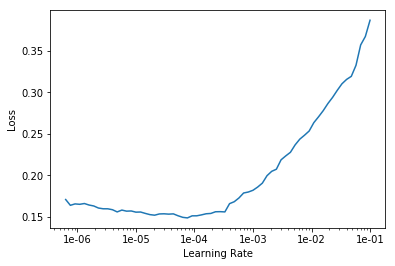

In [9]:
learner.recorder.plot()

In [20]:
lr2 = 1e-5

In [12]:
learner.fit_one_cycle(cyc_len=1, max_lr=slice(lr2, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.149396,0.119367,0.957096


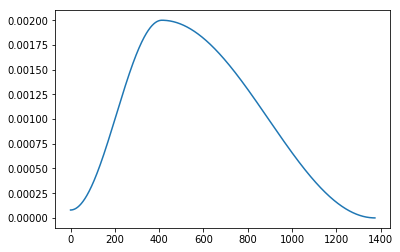

In [13]:
learner.recorder.plot_lr()

In [14]:
learner.save(f'{arch.__name__}-complete-1')

epoch,train_loss,valid_loss,accuracy
1,0.151710,0.132558,0.950710
2,0.117313,0.103587,0.963004


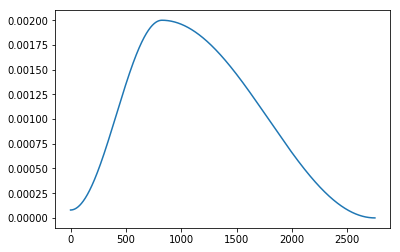

In [15]:
learner.fit_one_cycle(cyc_len=2, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-2')

epoch,train_loss,valid_loss,accuracy
1,0.139794,0.119252,0.957255
2,0.125170,0.115113,0.958164
3,0.107394,0.092442,0.967322
4,0.090649,0.090092,0.968890


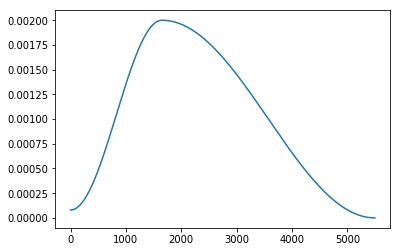

In [17]:
learner.fit_one_cycle(cyc_len=4, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-3')

epoch,train_loss,valid_loss,accuracy
1,0.108450,0.097394,0.965458
2,0.116108,0.106072,0.963095
3,0.112058,0.100635,0.964186
4,0.086022,0.084450,0.970912
5,0.082883,0.081713,0.970912
6,0.069958,0.077234,0.972321


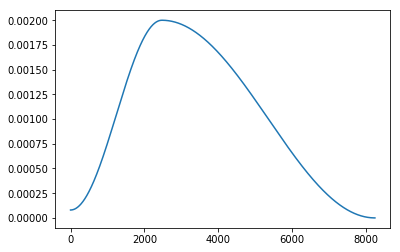

In [19]:
learner.fit_one_cycle(cyc_len=6, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-4')

epoch,train_loss,valid_loss,accuracy
1,0.072122,0.080197,0.971321
2,0.076660,0.087566,0.972162
3,0.077762,0.078887,0.972776
4,0.070409,0.076694,0.973139
5,0.070783,0.073485,0.974957
6,0.068790,0.072949,0.974435
7,0.067622,0.073835,0.974094
8,0.057429,0.073932,0.974026


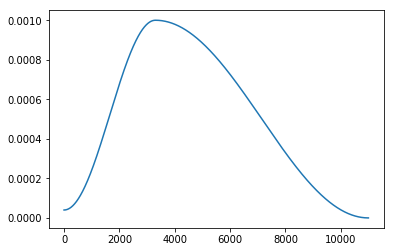

In [21]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(lr2/10, lr/10))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-5')

epoch,train_loss,valid_loss,accuracy
1,0.061565,0.073237,0.974798
2,0.058475,0.073333,0.974253
3,0.058036,0.073755,0.974412
4,0.064055,0.073075,0.974707
5,0.059303,0.071938,0.975116
6,0.061731,0.072562,0.975253
7,0.061684,0.072375,0.974912
8,0.056020,0.073141,0.974412


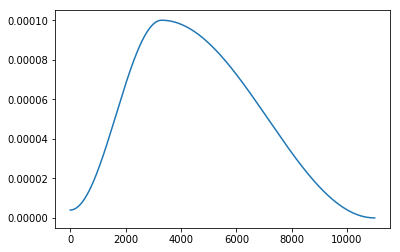

In [22]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(lr2/100, lr/100))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-6')

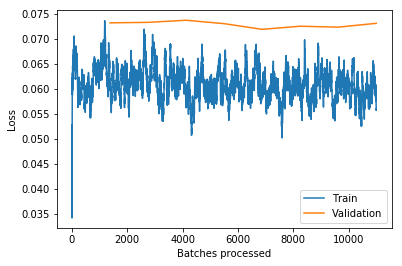

In [23]:
learner.recorder.plot_losses()

### One long cycle

In [10]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


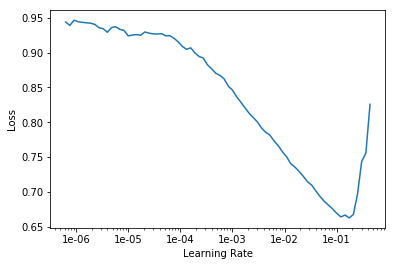

In [11]:
learner.recorder.plot()

In [12]:
lr = 3e-2

In [ ]:
learner.fit_one_cycle(cyc_len=1, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,auc_score_1,auc_score_2


In [ ]:
learner.recorder.plot_lr()
learner.recorder.plot_losses()

In [ ]:
nameHead = f'{arch.__name__}-cropped_{sz}-head'
learner.save(nameHead)

In [ ]:
#learner.load(nameHead)

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot()

In [63]:
lr2 = 

In [64]:
learner.fit_one_cycle(cyc_len=20, max_lr=slice(lr2, lr/10))

epoch,train_loss,valid_loss,accuracy,auc_score_1,auc_score_2
1,0.264650,0.249370,0.899489,0.958314,0.958314
2,0.257442,0.242547,0.901579,0.958139,0.958139
3,0.246819,0.228717,0.908010,0.964929,0.964929
4,0.242994,1.185465,0.907692,0.962728,0.962728
5,0.237852,0.809327,0.908465,0.957907,0.957909
6,0.229545,0.216781,0.913487,0.967241,0.967241
7,0.211172,0.211208,0.917009,0.969666,0.969666
8,0.202997,0.237449,0.921418,0.969433,0.969433
9,0.191996,5.928559,0.919396,0.967911,0.967911
10,0.184759,1.158651,0.920532,0.955892,0.955893


In [65]:
nameComplete = f'{arch.__name__}-cropped_{sz}-complete-2'
learner.save(nameComplete)

## Load

In [7]:
learner.load('')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image

# Validation Set TTA

In [ ]:
preds,y=learner.TTA(ds_type=DatasetType.Valid)

In [68]:
pred_score_tta_1=auc_score_1(preds,y)
pred_score_tta_1

tensor(0.9745)

In [69]:
pred_score_tta_2=auc_score_2(preds,y)
pred_score_tta_2

tensor(0.9745)

# Test Set TTA

In [70]:
preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test)

# Submission

In [77]:
sub=pd.read_csv(SAMPLE).set_index('id')
sub.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [78]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned=clean_fname(data.test_ds.items)
fname_cleaned=fname_cleaned.astype(str)

In [79]:
sub.loc[fname_cleaned,'label']=to_np(preds_test_tta[:,1])

In [80]:
n = 35
name = f'{n}-{arch.__name__}_sz{sz}_bs{bs}.csv'

In [81]:
sub.to_csv(SUBMISSIONS/name)

# .....

## Fastai Interpreter

In [23]:
interp = ClassificationInterpretation.from_learner(learner)

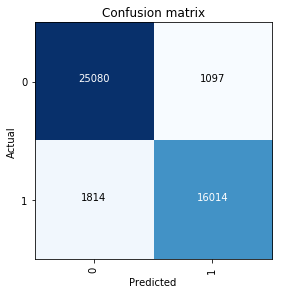

In [24]:
interp.plot_confusion_matrix()

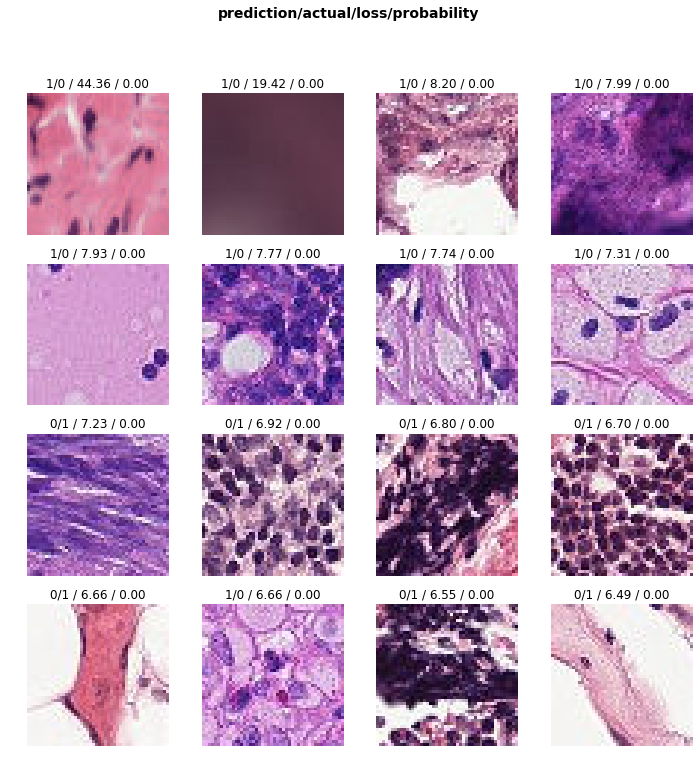

In [25]:
interp.plot_top_losses(16)

## ROC curve and AUC on validation set

In [26]:
preds_val, targets_val = learner.get_preds(ds_type=DatasetType.Valid)

In [27]:
fpr, tpr, thresholds, roc_auc = roc_curve_custom(preds_val, targets_val)

In [28]:
roc_auc

0.9793669042412114

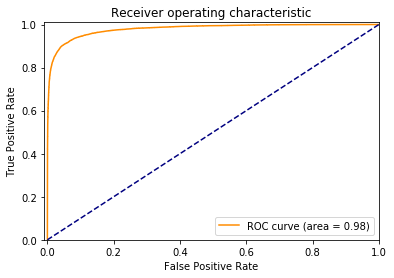

In [29]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Finding threshold on validation set

In [30]:
#learner.load('resnet34-complete')

In [31]:
import scipy.optimize as opt
from sklearn.model_selection import train_test_split

In [32]:
preds,y = learner.TTA(ds_type=DatasetType.Valid)

In [33]:
pred = preds[:, 1]

In [34]:
pred_tensor = pred
y_tensor = y

pred = np.asarray(pred)
y = np.asarray(y)

In [35]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(1)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [36]:
import sklearn
th = fit_val(pred, y)
print('Thresholds: ',th)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ', sklearn.metrics.f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))

Thresholds:  [0.606571]
F1 macro:  0.9245042532653246
F1 macro (th = 0.0):  0.28832500444746334
F1 micro:  0.9280763549596637


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score +=  sklearn.metrics.f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))


print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Thresholds:  [0.606507]
F1 macro avr: 0.9237156708067193
F1 macro:  0.9244827505491182
F1 micro:  0.9280536302692874
Fractions:  0.3774116577661629
Fractions (true):  0.40513578002499717


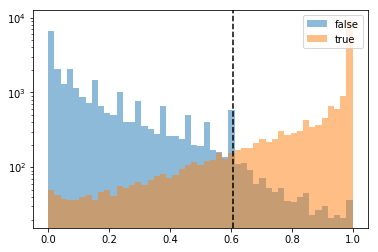

In [38]:
f1 =  sklearn.metrics.f1_score(y, pred>th, average=None)
bins = np.linspace(pred[:].min(), pred[:].max(), 50)
plt.hist(pred[y[:] == 0][:], bins, alpha=0.5, log=True, label='false')
plt.hist(pred[y[:] == 1][:], bins, alpha=0.5, log=True, label='true')
plt.legend(loc='upper right')
plt.axvline(x=th[0], color='k', linestyle='--')
plt.show()

## Predictions

In [39]:
preds, _ = learner.TTA(scale=1, ds_type=DatasetType.Test)
#preds, _ = learner.get_preds(ds_type=DatasetType.Test)

In [40]:
probs = np.array(preds[:,-1])

In [41]:
n = 34
#for th in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]:
for th in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    pred_labels = np.where(probs > th, 1, 0)
    df = pd.DataFrame({'id':[fname.split('.')[0] for fname in os.listdir(TEST)], 'label':pred_labels})
    name = f'{n}-{arch.__name__}_sz{sz}_bs{bs}_th{th}.csv'
    df.to_csv(SUBMISSIONS/name, header=True, index=False)
    n = n+1